In [1]:
import os
import pdb
import torchvision
import sys
import torch
import numpy as np

import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torchvision.transforms.functional as F
import torch.nn.functional as func

from tqdm import tqdm
from getopt import getopt
from math import floor, ceil
from torchvision import transforms
from optical_flow.model import LiteFlowNet

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

from optical_flow.visual import flow_to_color
from config import object_bbox_config as config

from util.process import score_norm

plt.switch_backend('agg')
%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
resolution = config["resolution"]

In [3]:
class GrayToRGB(object):
    def __call__(self, pic):
        if pic.size(0) == 1:
            return pic.repeat(3, 1, 1)
        elif pic.size(0) == 3:
            return pic
        else:
            return NotImplemented

def load_image(path, resolution):
    image = Image.open(path)
    transform = transforms.Compose([transforms.Resize(resolution), transforms.ToTensor(), GrayToRGB()])
    return transform(image)

In [4]:
import cv2

def get_optical_flow(model, path_former, path_latter, visual=True):
    
    former = load_image(path_former, resolution)
    latter = load_image(path_latter, resolution)

    width = former.size(2)
    height = former.size(1)

    process_former = former.to(device).view(1, 3, height, width)
    process_latter = latter.to(device).view(1, 3, height, width)

    process_width = int(floor(ceil(width / 32.0) * 32.0))
    process_height = int(floor(ceil(height / 32.0) * 32.0))

    process_former = torch.nn.functional.interpolate(input=process_former,
                                                     size=(process_height, process_width),
                                                     mode='bilinear',
                                                     align_corners=False)
    process_latter = torch.nn.functional.interpolate(input=process_latter,
                                                     size=(process_height, process_width),
                                                     mode='bilinear',
                                                     align_corners=False)

    result = model(process_former, process_latter)

    flow = torch.nn.functional.interpolate(input=result, size=(height, width), mode='bilinear', align_corners=False)

    flow[:, 0, :, :] *= float(width) / float(process_width)
    flow[:, 1, :, :] *= float(height) / float(process_height)

    out = flow[0, :, :, :].detach().cpu().numpy()

    if visual:
        
        flow_data_pil = np.array(out.transpose(1, 2, 0), np.float32)
        flow_data_hsv = flow_to_color(flow_data_pil, convert_to_bgr=False)
        plt.axis('off')
        plt.imshow(transforms.ToPILImage()(former))
        plt.savefig('origin.jpg')
    
    return out

In [5]:
def get_frame_sub(path_former, path_latter, visual=True):
    former = cv2.imread(path_former, cv2.IMREAD_GRAYSCALE)
    latter = cv2.imread(path_latter, cv2.IMREAD_GRAYSCALE)
    
    sub = cv2.subtract(latter, former)
    
    if visual:
        plt.imshow(sub)
        plt.savefig('subtract.jpg')
        pdb.set_trace()
        
    return sub[np.newaxis, :]

In [6]:
def get_bbox_feature(model, path_pic, opticalflow, visual_single=True, visual_all=True):

    pic = load_image(path_pic, resolution).to(device)
    opticalflow = torch.tensor(opticalflow).float().to(device)
    features = torch.cat((pic, opticalflow))

    temp = cv2.imread(path_pic)
    temp = cv2.resize(temp, resolution[: :-1], interpolation=cv2.INTER_CUBIC)
    predictions = model(temp)
    bboxes = predictions["instances"].pred_boxes.tensor

    if not bboxes.size(0) == 1:
        x1, y1, x2, y2 = torch.chunk(bboxes, 4, dim=1)
        area = ((y2 - y1) * (x2 - x1)).squeeze()
        idx = (area > area.mean() / 5).to(torch.bool)
        bboxes = bboxes[idx]
    
    return features, bboxes

/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


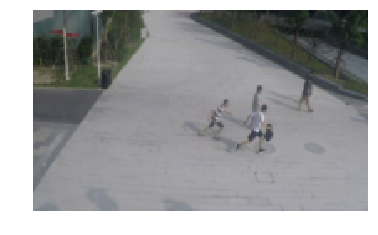

In [7]:
model = LiteFlowNet()
model.load_state_dict(torch.load('optical_flow/parameters.pt'))

model = model.to(device).eval()

path_former = "/Data/anomaly-detection-datasets/ShanghaiTech1/Test/Test007/0300.jpg"
path_latter = "/Data/anomaly-detection-datasets/ShanghaiTech1/Test/Test007/0303.jpg"
out = get_optical_flow(model, path_former, path_latter)

In [8]:
cfg = get_cfg()
cfg.merge_from_file("/Data/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = str(device)
cfg.MODEL.RPN.NMS_THRESH = 0.1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = "/Data/detectron2_repo/parameters/model_final_f10217.pkl"
model = DefaultPredictor(cfg)


path_pic = "/Data/anomaly-detection-datasets/ShanghaiTech1/Test/Test007/0300.jpg"
feature, bboxes = get_bbox_feature(model, path_pic, out)

Config '/Data/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [9]:
from model.crgan import Generator, SDiscriminator, RDiscriminator

g_model = Generator().to(device)
d_model_s = SDiscriminator().to(device)
d_model_r = RDiscriminator().to(device)

from config import benchmark

if benchmark == 'Avenue':
    models = torch.load('parameters/train_avenue_exp.pth')
elif benchmark == 'UCSDped1':
    models = torch.load('parameters/train_ucsd1_exp.pth')
elif benchmark == 'UCSDped2':
    models = torch.load('parameters/train_ucsd2_exp.pth')
elif benchmark == 'ShanghaiTech':
    models = torch.load('parameters/train_shanghaitech_exp.pth')
elif benchmark == 'ShanghaiTech1':
    models = torch.load('parameters/train_shanghaitech1_exp.pth')
elif benchmark == 'UMN':
    models = torch.load('parameters/train_umn_exp.pth')
    
g_model.load_state_dict(models['g_model'])
d_model_s.load_state_dict(models['d_model_s'])
d_model_r.load_state_dict(models['d_model_r'])

<All keys matched successfully>

In [10]:
bbox_size = (64, 64)

def bboxes2masks(inputs, bboxes):
    masks = torch.zeros(inputs.shape[0], 5, inputs.shape[2], inputs.shape[3]).to(inputs.device)
    for b, bbox in enumerate(bboxes):
        for points in bbox:
            x_0, y_0, x_1, y_1 = points
            width = x_1 - x_0
            height = y_1 - y_0
            i = int(round(y_0.item()))
            j = int(round(x_0.item()))
            h = int(round(height.item()))
            w = int(round(width.item()))
            masks[b, :3, i:i + h, j:j + w] = 1.0
    return masks


def bboxes2regions(inputs, bboxes):
    return torchvision.ops.roi_align(inputs, bboxes, bbox_size)

In [11]:
def forward(inputs, bboxes):
    inputs = inputs.unsqueeze(0)
    bboxes = bboxes.unsqueeze(0)
    with torch.set_grad_enabled(False):

        masks = bboxes2masks(inputs, bboxes)
        masked_inputs = inputs * (1 - masks)

        motion_condition = inputs[:, 3:]
        outputs = g_model(masked_inputs)
        outputs_condition = torch.cat([outputs, motion_condition], dim=1)
        prediction_scene = -d_model_s(outputs_condition)

        outputs_condition = outputs_condition

        output_regions = bboxes2regions(outputs_condition, [bboxes.squeeze(0)])
        prediction_regions = -d_model_r(output_regions)
    
    return prediction_regions.squeeze()

In [12]:
def get_score(features, bboxes, path_pic, visual=True):
    pic = load_image(path_pic, resolution).to(device)
    features = features.to(device)
    score = score_norm(forward(features, bboxes))
    
    score = score.detach().cpu().tolist()
    
    if visual:
        locs = bboxes.detach().cpu().numpy()
        pic = pic.detach().cpu()
        
        fig, ax = plt.subplots(1)
        plt.axis('off')
        plt.imshow(transforms.ToPILImage()(pic))

        for i, points in enumerate(locs):
            x_0, y_0, x_1, y_1 = points
            xy = (x_0, y_1)
            width = x_1 - x_0
            height = y_0 - y_1
            o_bbox = patches.Rectangle(xy, width, height, linewidth=1, facecolor='none',edgecolor='r')
            ax.add_patch(o_bbox)
            bbox = patches.Rectangle(xy, width, height, linewidth=1, edgecolor='r', facecolor='red', alpha=score[i] * 0.5)
            ax.add_patch(bbox)

        plt.savefig('score.jpg')
    
    return score

[1.0, 0.6811866164207458, 0.0, 0.5628011226654053]

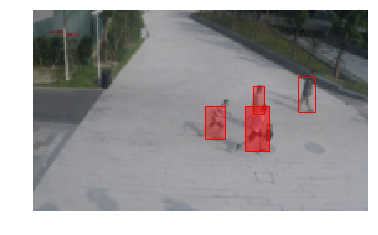

In [13]:
get_score(feature, bboxes, path_pic)

In [14]:
from torchvision import transforms
from torch.nn.functional import mse_loss

def get_heat(features, bboxes, path_pic, visual=True):
    pic = load_image(path_pic, resolution).to(device)
    features = features.to(device)
    
    inputs = features.unsqueeze(0)
    bboxes = bboxes.unsqueeze(0)
    with torch.set_grad_enabled(False):

        masks = bboxes2masks(inputs, bboxes)
        masked_inputs = inputs * (1 - masks)

        motion_condition = inputs[:, 3:]
        outputs = g_model(masked_inputs)
    plt.axis('off')
    att_img = mse_loss(pic, outputs.squeeze(), reduction='none').detach().cpu().permute(1,2,0)[:,:,0].numpy()
    
    att_img = att_img - att_img.min()
    att_img = att_img / att_img.max()
    att_img = (att_img * 255).astype(np.uint8)

    pic_img = transforms.ToPILImage()(pic.cpu())
    pic_img = cv2.cvtColor(np.asarray(pic_img), cv2.COLOR_RGB2BGR)
    
    att_img = cv2.applyColorMap(att_img, cv2.COLORMAP_HSV)
    att_img = cv2.GaussianBlur(att_img, (5, 5), 3)
    
    x = pic_img * 0.6 + att_img * 0.4
    x = x.astype(np.uint8)
    plt.imshow(x)

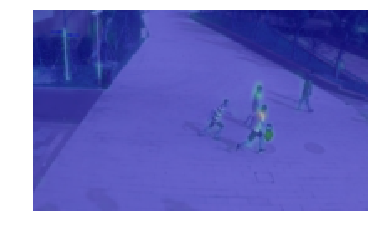

In [15]:
get_heat(feature, bboxes, path_pic)